### Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

To prevent elements such as Tensorflow import logs, perform these tasks.

In [2]:
import glob
import numpy as np
import tensorflow as tf
import IPython.display as display

### Convert raw files to TFRecord

In [3]:
def _bytes_feature(value: [str, bytes]) -> tf.train.Feature:
    """string / byte를 byte_list로 반환합니다."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList는 EagerTensor에서 문자열을 풀지 않습니다.
    
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [4]:
def _float_feature(value: float) -> tf.train.Feature:
    """float / double를 float_list로 반환합니다."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [5]:
def _int64_feature(value: [bool, int]) -> tf.train.Feature:
    """bool / enum / int / uint를 int64_list로 반환합니다."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
def serialize_example(image: bytes, label: int) -> tf.train.Example.SerializeToString:
    """
    파일을 만들기 위해서 tf.train.Example 메시지를 만듭니다.
    """
    feature = {
        "raw_image": _bytes_feature(image),
        "label": _int64_feature(label),
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [15]:
def write_tfrecord(main_path: str) -> None:
    """
    datset의 위치를 입력 받아, 이미지와 라벨 등을 구하여 반환한다.
    """
    train_paths = glob.glob(main_path + "/train/*/*.jpg")
    test_paths = glob.glob(main_path + "/test/*/*.jpg")
    image_labels = {"NonDemented": 0, "VeryMildDemented": 1, "MildDemented": 2, "ModerateDemented": 3}
    train_file = "./tfrecord/train.tfrecord"
    test_file = "./tfrecord/test.tfrecord"
    
    # train TFRecord file
    with tf.io.TFRecordWriter(train_file) as writer:
        for path in train_paths:
            image_string = open(path, "rb").read()
            
            label_str = path.split("\\")[1]
            label = image_labels[label_str]
            
            tf_example = serialize_example(image_string, label)
            writer.write(tf_example.SerializeToString())
        
        print("Train TFRecord Converting Done!")
    
    # test TFRecord file
    with tf.io.TFRecordWriter(test_file) as writer:
        for path in test_paths:
            image_string = open(path, "rb").read()
            
            label_str = path.split("\\")[1]
            label = image_labels[label_str]
            
            tf_example = serialize_example(image_string, label)
            writer.write(tf_example.SerializeToString())
        
        print("Test TFRecord Converting Done!")

In [16]:
dataset_path = "./dataset"
write_tfrecord(dataset_path)

Train TFRecord Converting Done!
Test TFRecord Converting Done!


### Read TFRecord file

In [17]:
train_dataset = tf.data.TFRecordDataset("./tfrecord/train.tfrecord")
test_dataset = tf.data.TFRecordDataset("./tfrecord/test.tfrecord")

In [18]:
image_feature_description = {
    "raw_image": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.int64),
}

In [19]:
@tf.autograph.experimental.do_not_convert
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [20]:
parsed_train_dataset = train_dataset.map(_parse_image_function)
parsed_test_dataset = test_dataset.map(_parse_image_function)

print(parsed_train_dataset)
print(parsed_test_dataset)

<MapDataset shapes: {label: (), raw_image: ()}, types: {label: tf.int64, raw_image: tf.string}>
<MapDataset shapes: {label: (), raw_image: ()}, types: {label: tf.int64, raw_image: tf.string}>


### Visualize dataset

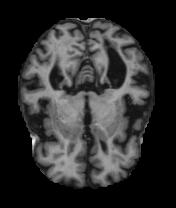

Label: 2


In [30]:
# train TFRecord
for image_features in parsed_train_dataset.take(1):
    image_raw = image_features["raw_image"].numpy()
    image_label = image_features["label"].numpy()
    display.display(display.Image(data=image_raw))
    print("Label:", image_label)

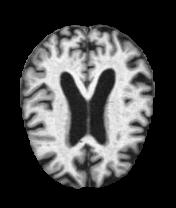

Label: 2


In [31]:
# test TFRecord
for image_features in parsed_test_dataset.take(1):
    image_raw = image_features["raw_image"].numpy()
    image_label = image_features["label"].numpy()
    display.display(display.Image(data=image_raw))
    print("Label:", image_label)

### Data preprocessing

In [ ]:
TRAIN_DATA_SIZE = len(list(parsed_train_dataset))
train_size = 
val_size = 